In [1]:
import os
import simulation
import pynbody
import pandas as pd
import matplotlib.pylab as plt
import matplotlib
import numpy as np
import ipywidgets
import tqdm
from simulation.sfh_in_box import sfh, plot_sfh, plot_binned_sfh, bin_sfh
from data_pd.dump_features import dump_features
from astropy import constants as c
from astropy.table import Table
from simulation.luminosity import surface_brightness, color_plot
from simulation.angmom import sideon
from simulation.derived import feh, mgfe, gas_metals

In [2]:
SIMPATH = '/home/michele/sim/MySimulations/ng'

In [3]:
SIM = 'mb.69002'
TRAJ = 'p300_a800_r600'

In [4]:
sim_path = os.path.join(SIMPATH, "{}_{}".format(SIM, TRAJ), "out")
NTH = 1
sim = simulation.Simulation(sim_path, snap_indexes=slice(None, 100, NTH))

loading simulation: /home/michele/sim/MySimulations/ng/mb.69002_p300_a800_r600/out
Found parameter file
Found compiler file
Found 563 snapshots
Taking 100 snapshots (slice(None, 100, 1))
Loading cosmological parameters
Found trace file


In [5]:
tbl = Table.read('/home/michele/sim/analysis/ng_ana/data_pd/{}_{}.fits'.format(SIM, TRAJ))

In [6]:
already_rotated = dict()

snap = sim[12]
snap.g['gas_metals']
tx = sideon(snap.s)


In [7]:
# tx.matrix @ np.array([0,1,0])

In [8]:
sl = ipywidgets.IntSlider(min=0, max=len(sim)-1, value=0, continuous_update=False)

In [9]:
def plot_maps(plots, width, band=None, cmap_name=None, norm=None, vrange=None):
    from mpl_toolkits.axes_grid1 import AxesGrid
    nplots = len(plots)
    fig = plt.figure(figsize=(12,4))
    grid = AxesGrid(fig, 111,  # similar to subplot(142)
                    nrows_ncols=(1, nplots),
                    axes_pad=0.5,
    #                 share_x=True,
    #                 share_all=False,
                    label_mode="all",
                    cbar_mode="each",
                    cbar_location="top",
                    cbar_size="3%",
                    cbar_pad="2%"
                   )

#     v_los_min, v_los_max = adjust_cbar_range(color_range)
#     sigma_min, sigma_max = adjust_cbar_range(sigma_range)
#     sb_min, sb_max = adjust_cbar_range(sb_range)
    if not isinstance(cmap_name, (list, tuple)):
        cmap_name = [cmap_name] * nplots
    if not isinstance(norm, (list, tuple)):
        norm = [norm] * nplots
    if vrange is None:
        vrange = [tuple(None, None)] * nplots
        
    cmap = list()
    for c in cmap_name:
        cmap.append(plt.get_cmap(c))
    
    extent = (-width/2, width/2, -width/2, width/2)

    im = list()
    cb = list()
    for i in range(nplots):
        im.append(grid[i].imshow(plots[i], extent=extent, cmap=cmap[i], origin='lower', norm=norm[i], vmin=vrange[i][0], vmax=vrange[i][1]))
#         b = grid[1].imshow(pl2, extent=extent, cmap=cmap[1], origin='lower')#, vmin=v_los_min, vmax=v_los_max)
#         c = grid[2].imshow(pl3, extent=extent, cmap=cmap[2], origin='lower')#, vmin=sigma_min, vmax=sigma_max)
        grid[i].set_xlabel('x/kpc')
        cb.append(grid.cbar_axes[i].colorbar(im[i]))

    #     grid[1].set_xlabel('x/kpc')
#     grid[2].set_xlabel('x/kpc')

    grid[0].set_ylabel('y/kpc')

#     cb1.set_label_text('$\mu_{}$'.format(band) if band is not None else '$\mu$' + ' [mag/arcsec$^2$]')

#     cb2 = grid.cbar_axes[1].colorbar(b)
#     cb2.set_label_text("$B-I$")

#     cb3 = grid.cbar_axes[2].colorbar(c)
#     cb3.set_label_text("$[Fe/H]$")
#     cb3.set_label_text("$Metals$")
    return grid

In [10]:
def h(i):
    bins = 100
    hist, binedges = bin_sfh(tbl['t'], tbl['sfr'], bins=bins)
    fig, ax = plt.subplots()
    left, right = binedges[:-1], binedges[1:]
    X = np.array([left, right]).T.flatten()
    Y = np.array([hist, hist]).T.flatten()
    ax.plot(X,Y, drawstyle='steps')

    max_sfr = np.max(hist)
    if ax.get_ylim()[1] < 1.2 * max_sfr:
        ax.set_ylim(0.0, 1.2 * max_sfr)
    ax.set_xlabel('Time [Gyr]')
    ax.set_ylabel('SFR [Msol/yr]')
    ax.axvline(tbl['t'][i], color='r', linewidth=0.5)

In [11]:
width=10

def k(i):
    snap = sim[i]
    pynbody.analysis.halo.center(snap.s)
    if i not in already_rotated:
        tx = sideon(snap.s)
        already_rotated[i] = tx.matrix
    rho = pynbody.plot.image(snap.g, resolution=100, qty='rho', av_z=False, width=width, log=True, noplot=True)#, vmin=-2.5, vmax=0);
    color = color_plot(snap, width=width, resolution=100, vmin=-0.5, vmax=2, noplot=True)#, mag_filter=None)
    fe = pynbody.plot.image(snap.g, resolution=100, av_z=True, qty='gas_metals', width=width, log=True, noplot=True)#, vmin=-2.5, vmax=0);
    print(fe.min(), fe.max())

    #     fe[np.where(fe == 0)] = abs(fe[np.where(abs(fe != 0))]).min()
    
#     temp = pynbody.plot.image(snap.g, av_z=True, qty='temp', width=width, log=False, noplot=True)#, vmin=-2.5, vmax=0);
    
    #     sb = surface_brightness(snap, cmap_name='gray', noplot=True, width=width)
#     fe = pynbody.plot.image(snap.s, av_z=True, qty='metals', width=width, log=False, noplot=True)#, vmin=-2.5, vmax=0);
    grid = plot_maps([rho, color, fe], width=width,
              cmap_name=['viridis', 'coolwarm', 'gray'], 
              norm=[matplotlib.colors.LogNorm(), None, matplotlib.colors.LogNorm()], 
              vrange=[(None, None)]*3)# +[(0.0001, 0.04)])
    y_prime = already_rotated[i] @ np.array([0,1,0])
    print(y_prime)
    norm = np.linalg.norm(y_prime)
    grid[0].arrow(0, 0,y_prime[0]/norm, y_prime[1]/norm, head_width=0.2, head_length=.2, color='red');
    return grid
#     plot_maps([rho, temp, color, fe], width=width,  cmap_name=['viridis', 'coolwarm', 'viridis', 'gray'])
from ipywidgets import VBox
w = ipywidgets.interactive(k, i=sl)
# w.children[-1].layout.height = '310px'
w1 = ipywidgets.interactive(h, i=sl)
wid = VBox([w, w1])
wid

In [11]:
bins = 100
hist, binedges = bin_sfh(tbl['t'], tbl['sfr'], bins=bins)

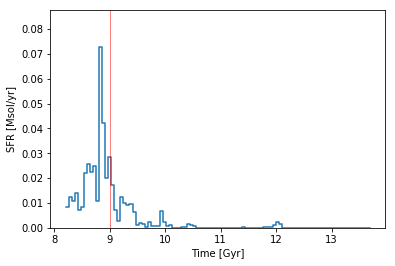

In [18]:
fig, ax = plt.subplots()
left, right = binedges[:-1], binedges[1:]
X = np.array([left, right]).T.flatten()
Y = np.array([hist, hist]).T.flatten()
ax.plot(X,Y, drawstyle='steps')

max_sfr = np.max(hist)
if ax.get_ylim()[1] < 1.2 * max_sfr:
    ax.set_ylim(0.0, 1.2 * max_sfr)
ax.set_xlabel('Time [Gyr]')
ax.set_ylabel('SFR [Msol/yr]')
ax.axvline(9, color='r', linewidth=0.5)